# Exploratory Analysis on Concern Levels


Xingjia Wang

Date: 07/08/2019

## Introduction

This document is an exploratory analysis on concern levels of each questionnaire section based on a further cleaned version of the YSET data (2008-2019.) 

The raw data was first processed by **csv_cleaning.py**, a cleaning script written by Aviva Prins which focuses on constructing a unique ID for each participant of the questionnaire. 

The output dataset was then processed by **questionDataCleaning.py**, another cleaning script written by Xingjia Wang which focuses on getting rid of invalid (e.g. large numbers outside of the choice range, etc.) and inconsistent (e.g. responses that says yes under IJ 6-months but no under IJ ever, etc.) responses. The output of this cleaning script contains *UniqueID*, responses to each question from *a1_combo* to *ij56_ever_combo* (binary/1-4/0-5,) *y_Flag_GangInvolvement* (binary, meaning whether the response suggests that the participant might be involved in a gang,) as well as *y_TotalFactors* (0-9, a risk factor determined by each section of the questionnaire.) It also contains columns that sum up all responses under each section, namely *Section_a* through *Section_ij_ever*.

Note that we only concern with Section A through IJ because these 9 sections are the determinant sections for program eligibility.

## Unit Import

In [1]:
import numpy as np
import pandas as pd
import re
import copy

from yellowbrick.features import Rank2D

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn import preprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.graphics.mosaicplot import mosaic

import warnings
warnings.filterwarnings('ignore')

## Data Import

This section imports data that has been processed through both cleaning scripts.

In [2]:
## Import data set for all questions
cleaned_filepath = "YSET_Data/YSET_Dec08_Dec19_a1_ij56ever_cleaned.csv"
df = pd.read_csv(cleaned_filepath)
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,UniqueID,a1_combo,a2_combo,a3_combo,a4_combo,a5_combo,a6_combo,b7_combo,b8_combo,b9_combo,...,Section_a,Section_b,Section_c,Section_de,Section_f,Section_g,Section_h,Section_t,Section_ij_6mos,Section_ij_ever
0,1010,1.0,5.0,3.0,1.0,1.0,1.0,3.0,5.0,3.0,...,12.0,11.0,4.0,15.0,17.0,8.0,15.0,2,0.0,NaN
1,1010,4.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,...,13.0,7.0,0.0,11.0,17.0,5.0,6.0,0,1.0,NaN
2,1042,2.0,2.0,3.0,1.0,3.0,1.0,4.0,3.0,3.0,...,12.0,10.0,4.0,13.0,21.0,17.0,26.0,2,6.0,6.0
3,1043,4.0,3.0,4.0,1.0,4.0,3.0,5.0,5.0,5.0,...,19.0,15.0,1.0,14.0,24.0,18.0,24.0,2,4.0,13.0
4,1043,2.0,3.0,3.0,1.0,2.0,2.0,3.0,3.0,3.0,...,13.0,9.0,1.0,13.0,19.0,13.0,15.0,2,0.0,12.0


## Extract Dataframe

In [4]:
## Create dataset for all sections

df_sect = copy.deepcopy(df.loc[:,"Section_a":"Section_ij_ever"])
df_sect['UniqueID'] = copy.deepcopy(df['UniqueID'])
cols = df_sect.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_sect = df_sect[cols]
df_sect['Section_ij'] = 0
df_sect['y_Flag_GangInvolvement'] = copy.deepcopy(df['y_Flag_GangInvolvement'])
df_sect['y_TotalFactors'] = copy.deepcopy(df['y_TotalFactors'])
df_sect = df_sect.join(copy.deepcopy(df.loc[:,'Age':'Ethnicity_Other']))
df_sect.head()

,UniqueID,Section_a,Section_b,Section_c,Section_de,Section_f,Section_g,Section_h,Section_t,Section_ij_6mos,...,y_TotalFactors,Age,Date,Gender,GRYD_Zone,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Latino,Ethnicity_White,Ethnicity_Other
0,1010,12.0,11.0,4.0,15.0,17.0,8.0,15.0,2,0.0,...,NaN,16.0,2010-05-13,2.0,5.0,0.0,0.0,1.0,0.0,0.0
1,1010,13.0,7.0,0.0,11.0,17.0,5.0,6.0,0,1.0,...,1.0,18.0,2011-07-28,2.0,5.0,0.0,0.0,1.0,0.0,0.0
2,1042,12.0,10.0,4.0,13.0,21.0,17.0,26.0,2,6.0,...,7.0,18.0,2011-09-27,1.0,7.0,0.0,0.0,1.0,0.0,0.0
3,1043,19.0,15.0,1.0,14.0,24.0,18.0,24.0,2,4.0,...,8.0,15.0,2010-05-17,NaN,5.0,0.0,0.0,1.0,0.0,0.0
4,1043,13.0,9.0,1.0,13.0,19.0,13.0,15.0,2,0.0,...,NaN,16.0,2011-07-27,1.0,5.0,0.0,0.0,1.0,0.0,0.0


In [9]:
df_sect.y_Flag_GangInvolvement.value_counts()

0    25233
1     7663
Name: y_Flag_GangInvolvement, dtype: int64

## Convert Score Scales to Concern Levels

In [5]:
def Scale2Concern(row):
    '''
    Scale2Concern
    
    @brief A function that determines the concern level for each section in one questionnaire response (one row of data with section scores)
    
    @param <Series> row: a response of the questionnaire
    
    '''
    
    ## Section a
    if row.Section_a < 16:
        row.Section_a = 0
    elif row.Section_a < 18:
        row.Section_a = 1
    elif row.Section_a < 20:
        row.Section_a = 2
    elif row.Section_a < 22:
        row.Section_a = 3
    else: row.Section_a = 4  
      
    ## Section b
    if row.Age >12:
        if row.Section_b < 7:
            row.Section_b = 0
        elif row.Section_b < 9:
            row.Section_b = 1
        elif row.Section_b < 11:
            row.Section_b = 2
        elif row.Section_b < 14:
            row.Section_b = 3
        else: row.Section_b = 4
    else:
        if row.Section_b < 7:
            row.Section_b = 0
        elif row.Section_b < 9:
            row.Section_b = 1
        elif row.Section_b < 10:
            row.Section_b = 2
        elif row.Section_b < 12:
            row.Section_b = 3
        else: row.Section_b = 4
                
    ## Section c         
    if row.Section_c < 4: 
        row.Section_c = 0
    elif row.Section_c == 4:
        row.Section_c = 1
    elif row.Section_c == 5:
        row.Section_c = 2
    elif row.Section_c == 6:
        row.Section_c = 3
    else: row.Section_c = 4 
        
    ##Section de
    if row.Age >12:
        if row.Section_de < 14:
            row.Section_de = 0
        elif row.Section_de < 16:
            row.Section_de = 1
        elif row.Section_de < 18:
            row.Section_de = 2
        elif row.Section_de < 19:
            row.Section_de = 3
        else: row.Section_de = 4
    else:
        if row.Section_de < 14:
            row.Section_de = 0
        elif row.Section_de < 16:
            row.Section_de = 1
        elif row.Section_de < 17:
            row.Section_de = 2
        elif row.Section_de < 18:
            row.Section_de = 3
        else: row.Section_de = 4
        
    ## Section f 
    if row.Age >12:
        if row.Section_f < 19:
            row.Section_f = 0
        elif row.Section_f < 22:
            row.Section_f = 1
        elif row.Section_f < 25:
            row.Section_f = 2
        elif row.Section_f < 27:
            row.Section_f = 3
        else: row.Section_f = 4
    else:
        if row.Section_f < 19:
            row.Section_f = 0
        elif row.Section_f < 21:
            row.Section_f = 1
        elif row.Section_f < 23:
            row.Section_f = 2
        elif row.Section_f < 25:
            row.Section_f = 3
        else: row.Section_f = 4
        
    ## Section g
    if row.Section_g < 13:
        row.Section_g = 0
    elif row.Section_g < 17:
        row.Section_g = 1
    elif row.Section_g < 19:
        row.Section_g = 2
    elif row.Section_g < 21:
        row.Section_g = 3
    else: row.Section_g = 4
        
    ## Section h 
    if row.Age >12:
        if row.Section_h < 14:
            row.Section_h = 0
        elif row.Section_h < 17:
            row.Section_h = 1
        elif row.Section_h < 20:
            row.Section_h = 2
        elif row.Section_h < 23:
            row.Section_h = 3
        else: row.Section_h = 4
    else:
        if row.Section_h < 12:
            row.Section_h = 0
        elif row.Section_h < 14:
            row.Section_h = 1
        elif row.Section_h < 15:
            row.Section_h = 2
        elif row.Section_h < 17:
            row.Section_h = 3
        else: row.Section_h = 4
    
    ## Section t
    if row.Section_t == 2: 
        row.Section_t = 3
        
    ## Section ij 6 8 10 13    
    if row.Age >12:
        if row.Section_ij_6mos < 6 or row.Section_ij_ever < 6: 
            pass
        elif row.Section_ij_6mos < 8 or row.Section_ij_ever < 8: 
            row.Section_ij = 1
        elif row.Section_ij_6mos < 10 or row.Section_ij_ever < 10: 
            row.Section_ij = 2
        elif row.Section_ij_6mos < 13 or row.Section_ij_ever < 13: 
            row.Section_ij = 3
        else: row.Section_ij = 4
    else:
        if row.Section_ij_6mos < 4 or row.Section_ij_ever < 4: 
            pass
        elif row.Section_ij_6mos < 6 or row.Section_ij_ever < 6: 
            row.Section_ij = 1
        elif row.Section_ij_6mos < 8 or row.Section_ij_ever < 8: 
            row.Section_ij = 2
        elif row.Section_ij_6mos < 10 or row.Section_ij_ever < 10: 
            row.Section_ij = 3
        else: row.Section_ij = 4
        
    return row

In [6]:
df_sect=df_sect.apply(Scale2Concern, axis = 1)

df_sect.drop('Section_ij_6mos', axis = 1, inplace = True)
df_sect.drop('Section_ij_ever', axis = 1, inplace = True)

cols = df_sect.columns.tolist()
cols = cols[:-3] + cols[-3:][::-1]

df_sect = df_sect[cols]

df_sect.head()

,UniqueID,Section_a,Section_b,Section_c,Section_de,Section_f,Section_g,Section_h,Section_t,Section_ij,...,y_TotalFactors,Age,Date,Gender,GRYD_Zone,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Other,Ethnicity_White,Ethnicity_Latino
0,1010,0,3,1,1,0,0,1,3,0,...,NaN,16.0,2010-05-13,2.0,5.0,0.0,0.0,0.0,0.0,1.0
1,1010,0,1,0,0,0,0,0,0,0,...,1.0,18.0,2011-07-28,2.0,5.0,0.0,0.0,0.0,0.0,1.0
2,1042,0,2,1,0,1,2,4,3,1,...,7.0,18.0,2011-09-27,1.0,7.0,0.0,0.0,0.0,0.0,1.0
3,1043,2,4,0,1,2,2,4,3,0,...,8.0,15.0,2010-05-17,NaN,5.0,0.0,0.0,0.0,0.0,1.0
4,1043,0,2,0,0,1,1,1,3,0,...,NaN,16.0,2011-07-27,1.0,5.0,0.0,0.0,0.0,0.0,1.0


In [10]:
df_csv = copy.deepcopy(df_sect.loc[:,'UniqueID':'Section_ij'])
df_csv['y_TotalFactors'] = copy.deepcopy(df_sect['y_TotalFactors'])
df_csv.to_csv('YSET_Data/ConcernLv_RF.csv')

In [11]:
df_csv.head()

,UniqueID,Section_a,Section_b,Section_c,Section_de,Section_f,Section_g,Section_h,Section_t,Section_ij,y_TotalFactors
0,1010,0,3,1,1,0,0,1,3,0,NaN
1,1010,0,1,0,0,0,0,0,0,0,1.0
2,1042,0,2,1,0,1,2,4,3,1,7.0
3,1043,2,4,0,1,2,2,4,3,0,8.0
4,1043,0,2,0,0,1,1,1,3,0,NaN


## Reconstruction of Risk Factor with Given Instructions

In [12]:
def riskFactor(row):
    '''
    riskFactor
    
    @brief A function that determines the risk factor score for one questionnaire response (one row of data with section scores)
    
    @param <Series> row: a response of the questionnaire
    
    @return <int> total: determined risk factor score
    '''
    total = 0
    for col in df_sect.loc[:,'Section_a':'Section_ij'].columns.tolist():
        if row[col] != 0:
            total+=1
    return total

In [13]:
## Constructing the RiskFactor variable by applying riskFactor to each row of df_sect

df_sect['RiskFactor'] = df_sect.apply(riskFactor, axis = 1)
df_sect['RiskFactor'] = pd.to_numeric(df_sect['RiskFactor'], downcast = 'integer', errors = 'coerce')

### Consistency with the original '*y_TotalFactors*' variable 

In [14]:
n_tot = len(df_sect)
n_incons = df_sect.loc[df_sect.y_TotalFactors!=df_sect.RiskFactor].loc[df_sect.y_TotalFactors.isna() == False].shape[0]
n_diffby1 = df_sect.loc[df_sect.y_TotalFactors!=df_sect.RiskFactor].loc[df_sect.y_TotalFactors.isna() == False].loc[abs(df_sect.y_TotalFactors-df_sect.RiskFactor) == 1].shape[0]

print("Total # of responses: {}".format(n_tot))
print("# of inconsistencies: {}, accounting for {}% of the entire data.".format(n_incons, n_incons*100//n_tot))
print("# of inconsistencies that differ only by 1 between the constructed and original variables: {}, accounting for {}% of the inconsistent data.".format(n_diffby1, n_diffby1*100//n_incons) )

Total # of responses: 32896
# of inconsistencies: 2944, accounting for 8% of the entire data.
# of inconsistencies that differ only by 1 between the constructed and original variables: 2943, accounting for 99% of the inconsistent data.


### Exploring inconsistent entries

In [15]:
df_incon = df_sect.loc[df_sect.y_TotalFactors!=df_sect.RiskFactor].loc[df_sect.y_TotalFactors.isna() == False]

Text(0.5,1,'Histogram of Reconstructed Risk Factors')

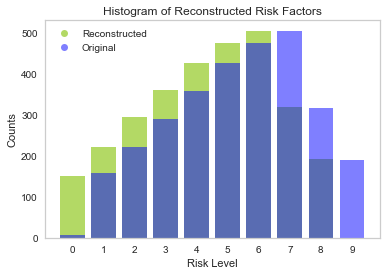

In [22]:
import matplotlib.lines
a=np.append(df_incon['RiskFactor'].value_counts().to_numpy(), [0])
b=np.append(np.array(df_incon['RiskFactor'].value_counts().index),[9])
c=np.append(df_incon['y_TotalFactors'].value_counts().to_numpy(), [0])
d=np.append(np.array(df_incon['y_TotalFactors'].value_counts().index),[9])

plt.grid(b=None)
plt.bar(b, a, alpha=0.75, color = 'YellowGreen')
plt.bar(d, c, alpha=0.5, color = 'Blue')
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='YellowGreen', alpha = 0.75, marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='Blue', alpha = 0.5, marker = 'o')
plt.legend([scatter1_proxy, scatter2_proxy], ['Reconstructed', 'Original'], numpoints = 1)
plt.xlabel('Risk Level')
plt.xticks(np.arange(0, 10))
plt.ylabel('Counts')
plt.title('Histogram of Reconstructed Risk Factors')

In [17]:
df_incon.head()

,UniqueID,Section_a,Section_b,Section_c,Section_de,Section_f,Section_g,Section_h,Section_t,Section_ij,...,Age,Date,Gender,GRYD_Zone,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Other,Ethnicity_White,Ethnicity_Latino,RiskFactor
3,1043,2,4,0,1,2,2,4,3,0,...,15.0,2010-05-17,NaN,5.0,0.0,0.0,0.0,0.0,1.0,7
10,1088,0,0,0,1,0,1,3,1,0,...,17.0,2011-08-12,1.0,5.0,0.0,0.0,0.0,0.0,1.0,4
13,1098,1,0,0,0,1,0,0,1,0,...,13.0,2010-05-06,1.0,5.0,0.0,0.0,0.0,0.0,1.0,3
14,1098,1,0,2,0,0,1,0,0,0,...,14.0,2011-08-04,1.0,5.0,0.0,0.0,0.0,0.0,1.0,3
22,1128,0,2,0,0,1,0,1,0,0,...,17.0,2011-08-31,1.0,22.0,0.0,0.0,0.0,0.0,1.0,3


In [75]:
df_incon.Ethnicity_Latino.value_counts()

1.0    2218
0.0     722
Name: Ethnicity_Latino, dtype: int64

In [70]:
1905.0/(1905+1011)

0.6532921810699589

In [77]:
df_sect.GRYD_Zone.value_counts()

1.0     2694
11.0    2554
21.0    2492
5.0     2425
22.0    2264
12.0    2230
14.0    2057
9.0     1949
2.0     1772
17.0    1466
23.0    1443
3.0     1306
20.0    1218
7.0     1215
19.0     803
15.0     797
18.0     787
13.0     769
4.0      618
8.0      557
10.0     503
6.0      271
16.0     115
Name: GRYD_Zone, dtype: int64

In [69]:
 19281.0/(19281+13404)

0.5899036255162918

In [76]:
df_sect.Ethnicity_Latino.value_counts()

1.0     25020
0.0      7829
11.0        2
Name: Ethnicity_Latino, dtype: int64

Look at date tested and gryd zone

## Exploring Correlations between Sections

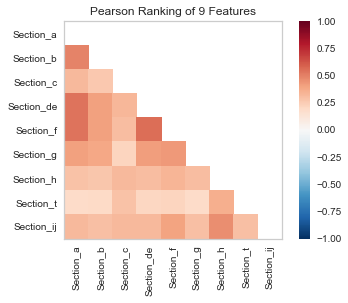

In [15]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(df_sect.loc[:,'Section_a':'Section_ij'])
visualizer.poof()

## Dimension Reduction: PCA (Sections Only)

In [17]:
X_sect =df_sect.loc[:,"Section_a":"Section_ij"]
X_sect.dropna(inplace = True)
X_sect.head(3)

,Section_a,Section_b,Section_c,Section_de,Section_f,Section_g,Section_h,Section_t,Section_ij
0,0.0,3.0,1.0,1.0,0.0,0.0,1.0,3.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,1.0,0.0,1.0,2.0,4.0,3.0,1.0


#### Reduce to 2 Dimensions:

In [18]:
n = 2
min_max_scaler = preprocessing.MinMaxScaler()
X_sect_minmax = min_max_scaler.fit_transform(X_sect)

sect_pca = PCA(n_components = n, random_state=1)
X_sect_pca = sect_pca.fit_transform(X_sect_minmax)
print("% variance explained by selected principle components: {}%".format((sect_pca.explained_variance_ratio_.cumsum()[n-1]*100000//10)/100))

print("By each principle component: {}%, {}%".format((sect_pca.explained_variance_ratio_[0]*100000//10)/100, (sect_pca.explained_variance_ratio_[1]*100000//10)/100))

% variance explained by selected principle components: 56.04%
By each principle component: 42.95%, 13.08%


#### Reduce to 3 Dimensions:

In [19]:
n = 3

sect_pca3 = PCA(n_components = n, random_state=1)
X_sect_pca3 = sect_pca3.fit_transform(X_sect_minmax)
print("% variance explained by selected principle components: {}%".format((sect_pca3.explained_variance_ratio_.cumsum()[n-1]*100000//10)/100))

print("By each principle component: {}%, {}%, {}%".format((sect_pca3.explained_variance_ratio_[0]*100000//10)/100, (sect_pca3.explained_variance_ratio_[1]*100000//10)/100, (sect_pca3.explained_variance_ratio_[2]*100000//10)/100))

% variance explained by selected principle components: 64.74%
By each principle component: 42.95%, 13.08%, 8.7%


## Unsupervised Clustering (Sections Only)

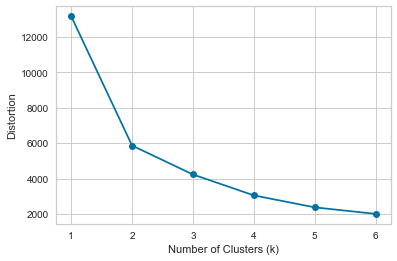

In [20]:
distortions = []
K_to_try = range(1, 7)
for i in K_to_try:
    model = KMeans(
            n_clusters=i,
            init='k-means++',
            n_jobs=-1,
            random_state=1)
    model.fit(X_sect_pca)
    distortions.append(model.inertia_)
plt.plot(K_to_try, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.show()

### KMeans: 2D

In [21]:
# use the best K from elbow method
model = KMeans(
    n_clusters=2,
    init='k-means++',
    n_jobs=-1,
    random_state=1)
model = model.fit(X_sect_pca)
y_sect_pca = model.predict(X_sect_pca)

In [23]:
df_sect_pca2 = pd.DataFrame(data={'KMeans':y_sect_pca,'PCA1': X_sect_pca[:, 0], 'PCA2': X_sect_pca[:, 1]})
df_sect_pca2['UniqueID'] = copy.deepcopy(df['UniqueID'])
df_sect_pca2['y_Flag_GangInvolvement'] = copy.deepcopy(df_sect['y_Flag_GangInvolvement'])
df_sect_pca2.dropna(inplace = True)
df_sect_pca2[df_sect_pca2['KMeans'] == 0].head()

,KMeans,PCA1,PCA2,UniqueID,y_Flag_GangInvolvement
1,0,-0.459641,-0.102802,1010,0.0
4,0,0.123718,0.585365,1043,1.0
5,0,-0.239273,0.654553,1083,1.0
6,0,-0.155151,0.174489,1083,0.0
8,0,0.208076,0.877373,1085,1.0


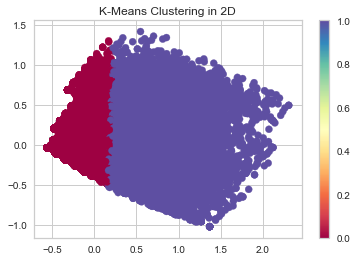

In [24]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X_sect_pca[:,0],X_sect_pca[:,1],
                     c=y_sect_pca,s=50, cmap = 'Spectral')
ax.set_title('K-Means Clustering in 2D')
plt.colorbar(scatter)

#### Looking at difference between clusters

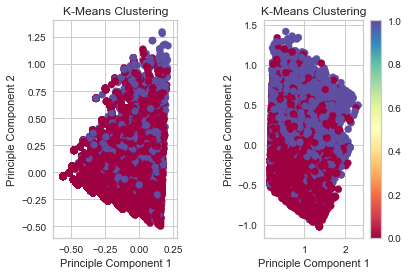

In [25]:
# 2D PCA 2 Clusters:
k = 0
fig = plt.figure()
fig.subplots_adjust(wspace = 0.7)
ax = fig.add_subplot(121)
scatter = ax.scatter(df_sect_pca2[df_sect_pca2['KMeans'] == k]['PCA1'],df_sect_pca2[df_sect_pca2['KMeans'] == k]['PCA2'],
                     c=df_sect_pca2[df_sect_pca2['KMeans'] == k]['y_Flag_GangInvolvement'],s=50, cmap = 'Spectral')
ax.set_title('K-Means Clustering')
ax.set_xlabel('Principle Component 1')
ax.set_ylabel('Principle Component 2')

k = 1
ax1 = fig.add_subplot(122)
scatter1 = ax1.scatter(df_sect_pca2[df_sect_pca2['KMeans'] == k]['PCA1'],df_sect_pca2[df_sect_pca2['KMeans'] == k]['PCA2'],
                     c=df_sect_pca2[df_sect_pca2['KMeans'] == k]['y_Flag_GangInvolvement'],s=50, cmap = 'Spectral')
ax1.set_title('K-Means Clustering')
ax1.set_xlabel('Principle Component 1')
ax1.set_ylabel('Principle Component 2')

plt.colorbar(scatter)

### KMeans: 3D

In [26]:
# use the best K from elbow method
model3 = KMeans(
    n_clusters=2,
    init='k-means++',
    n_jobs=-1,
    random_state=2)
model3 = model3.fit(X_sect_pca3)
y_sect_pca3 = model3.predict(X_sect_pca3)

In [27]:
df_sect_pca3 = pd.DataFrame(data={'KMeans':y_sect_pca3,'PCA1': X_sect_pca3[:, 0], 'PCA2': X_sect_pca3[:, 1], 'PCA3': X_sect_pca3[:, 2]})
df_sect_pca3['UniqueID'] = copy.deepcopy(df['UniqueID'])
df_sect_pca3['y_Flag_GangInvolvement'] = copy.deepcopy(df_sect['y_Flag_GangInvolvement'])
df_sect_pca3.dropna(inplace = True)
df_sect_pca3[df_sect_pca3['KMeans'] == 0].head()

,KMeans,PCA1,PCA2,PCA3,UniqueID,y_Flag_GangInvolvement
0,0,0.224217,0.620800,-0.668935,1010,1.0
2,0,0.523332,0.951082,-0.499607,1042,1.0
3,0,1.022385,0.480880,-0.781039,1043,1.0
7,0,0.492119,0.639200,0.060319,1085,0.0
9,0,0.805283,1.130781,0.252633,1088,1.0


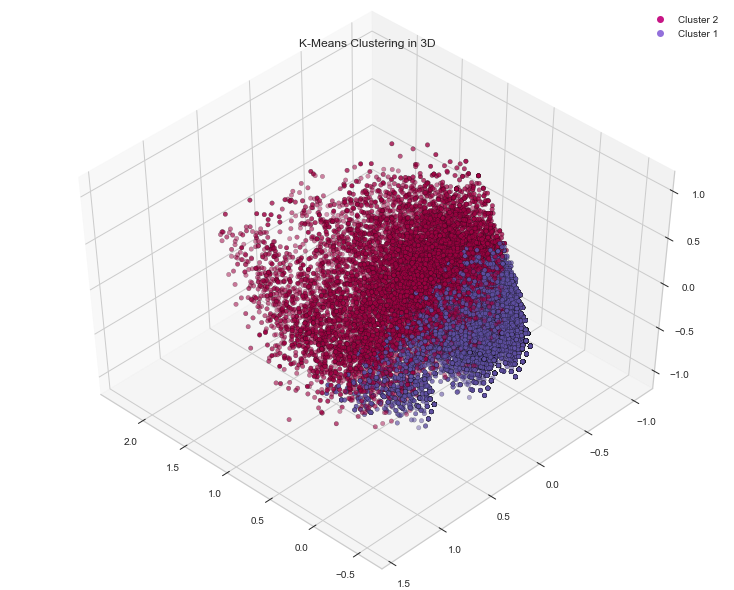

In [31]:
import matplotlib.lines

fig = plt.figure(1, figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, elev=48, azim=134)

scatter = ax.scatter(X_sect_pca3[:, 0], X_sect_pca3[:, 1], X_sect_pca3[:, 2], c=y_sect_pca3, 
           edgecolor='k', cmap = 'Spectral')

scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='MediumVioletRed', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='MediumPurple', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['Cluster 2', 'Cluster 1'], numpoints = 1)

ax.set_title('K-Means Clustering in 3D')
plt.show()

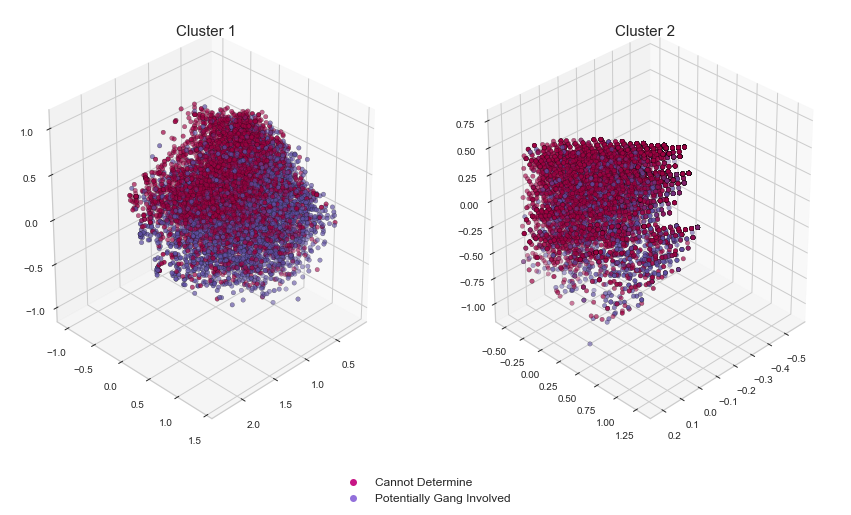

In [32]:
# 2D PCA 2 Clusters:
k = 0
fig = plt.figure( figsize=(15, 8))
fig.subplots_adjust(wspace = 0.1)
ax = fig.add_subplot(121, projection='3d', elev=30, azim=45)
scatter = ax.scatter(df_sect_pca3[df_sect_pca3['KMeans'] == k]['PCA1'], 
           df_sect_pca3[df_sect_pca3['KMeans'] == k]['PCA2'], 
           df_sect_pca3[df_sect_pca3['KMeans'] == k]['PCA3'],
           c=df_sect_pca3[df_sect_pca3['KMeans'] == k]['y_Flag_GangInvolvement'], 
           edgecolor='k', cmap = 'Spectral')
ax.set_title('Cluster 1', fontsize = 15)


k = 1
ax1 = fig.add_subplot(122, projection='3d', elev=30, azim=45)
ax1.scatter(df_sect_pca3[df_sect_pca3['KMeans'] == k]['PCA1'], 
           df_sect_pca3[df_sect_pca3['KMeans'] == k]['PCA2'], 
           df_sect_pca3[df_sect_pca3['KMeans'] == k]['PCA3'],
           c=df_sect_pca3[df_sect_pca3['KMeans'] == k]['y_Flag_GangInvolvement'], 
           edgecolor='k', cmap = 'Spectral')
ax1.set_title('Cluster 2', fontsize = 15)

scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='MediumVioletRed', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='MediumPurple', marker = 'o')
fig.legend([scatter1_proxy, scatter2_proxy], ['Cannot Determine', 'Potentially Gang Involved'], numpoints = 1, loc='lower center',fontsize = 12)

plt.show()

In [34]:
cleanup_nums = {"KMeans":     {0 : "Cluster 1", 1 : "Cluster 2"},
                "y_Flag_GangInvolvement": { 1:"Potentially Gang Involved",  0: "Cannot Determine if Involved"}}

cols2d = df_sect_pca2.columns.tolist()
cols2d = cols2d[1:] + cols2d[0:1]
cols2d = cols2d[2:] + cols2d[0:2]
df_sect_pca2= df_sect_pca2[cols2d]
df_sect_pca2.replace(cleanup_nums, inplace=True)
df_sect_pca2.head()

cols3d = df_sect_pca3.columns.tolist()
cols3d = cols3d[1:] + cols3d[0:1]
cols3d = cols3d[3:] + cols3d[0:3]
df_sect_pca3= df_sect_pca3[cols3d]
df_sect_pca3.replace(cleanup_nums, inplace=True)
df_sect_pca3.head()

,UniqueID,y_Flag_GangInvolvement,KMeans,PCA1,PCA2,PCA3
0,1010,Potentially Gang Involved,Cluster 1,0.224217,0.620800,-0.668935
1,1010,Cannot Determine if Involved,Cluster 2,-0.459641,-0.102802,-0.188188
2,1042,Potentially Gang Involved,Cluster 1,0.523332,0.951082,-0.499607
3,1043,Potentially Gang Involved,Cluster 1,1.022385,0.480880,-0.781039
4,1043,Potentially Gang Involved,Cluster 2,0.123718,0.585365,-0.599567


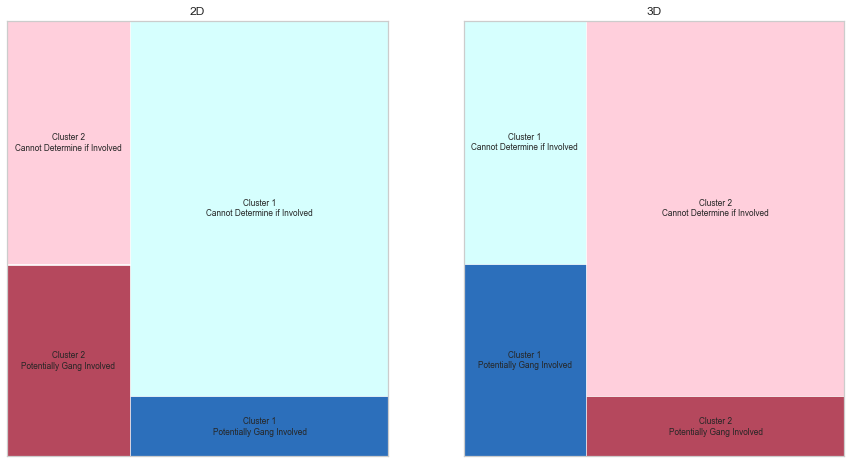

In [35]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(121)
plt.rcParams['font.size'] = 10
props = {}
props[('Cluster 1', 'Potentially Gang Involved')] = {'color': 'xkcd:medium blue'}
props[('Cluster 1','Cannot Determine if Involved')] = {'color': 'xkcd:very pale blue'}
props[('Cluster 2', 'Potentially Gang Involved')] = {'color': 'xkcd:dark rose'}
props[('Cluster 2','Cannot Determine if Involved')] = {'color': 'xkcd:pale pink'}
mosaic2d = mosaic(df_sect_pca2, ['KMeans', 'y_Flag_GangInvolvement'], axes_label = False, ax = ax1, properties=props)
ax1.set_title('2D')

ax2 = fig.add_subplot(122)
mosaic3d = mosaic(df_sect_pca3, ['KMeans', 'y_Flag_GangInvolvement'], axes_label = False, ax = ax2, properties=props)
ax2.set_title('3D')

plt.show()